# Reservoir Computing with Genetic Oscillators for Arrhythmia Classification Tutorial

In this notebook, we will guide you through a comprehensive tutorial on utilizing our genetic oscillator-based reservoir for reservoir computing to classify ECG signals into 5 different categories of arrhythmia. It provides a deep dive into the implementation and usage of our innovative approach.

Please note that due to the computational complexity of certain sections, we will be loading results from previous runs stored in local storage. These stored results are not available as part of the GitHub repository but are essential for reproducing our experiments and understanding the tutorial.

Throughout the tutorial, we will also incorporate various visualization techniques to facilitate a better understanding of the internal workings of our reservoir and the dataset.

Now lets explore the potential of reservoir computing for arrhythmia classification using genetic oscillators.


## 1. Setup

### 1.1 Ensuring Reproducibility
To ensure reproducibility of our experiments, we fix the random state of our system with a static seed. This guarantees that the same results will be obtained each time the code is run.

In [1]:
import numpy as np
import reservoirpy as rpy

# Define global seed for random state generators
SEED = 1234

# Set reservoirpy verbosity to 1 (enabled)
VERBOSITY = 0

# Fix our random state generators
rpy.set_seed(SEED)
np.random.seed(SEED)

# set reservoirpy verbosity to 0 (OFF)
rpy.verbosity(VERBOSITY)

0

### 1.1 Initializing the Logger

In this section, we establish logging to capture detailed information throughout our tutorial. We import a custom `Logger` class from `utils.logger`, designed to streamline logging operations.

Our `Logger` class, built upon Python's `logging` module, enables parallel writes to both stream and file while maintaining a single handler per type. This setup ensures efficient tracking of hyperparameters and metrics, vital for effective model evaluation and debugging.

In [2]:
from utils.logger import Logger

# Set our logging level to 1 (DEBUG)
LOG_LEVEL = 1

# Initialize our logger with a log file
log_name = "reservoir-computing-tutorial"
log_file = f"logs/{log_name}.log"
logger = Logger(level=LOG_LEVEL, log_file=log_file)

## 2. Visualizing ECGs

This section focuses on visualizing an electrocardiogram (ECG) waveform, including a sampled segment, to visualize our dataset

We begin by loading our forecasting ECG data using a function from our `utils.preprocessing` module, setting the number of timesteps to `2000`. The function returns the ECG data as `X_forecast`.

Notably, we will not be using this dataset for classification, we will be using segments of it, but it is perfect for visualization.

### 2.1 Loading a Full ECG Signal
Here we load an ECG signal of 2000 timesteps from our forecasting dataset.

As mentioned, we will be using 187 timestep, labeled, segments of this dataset for our classification task.

In [3]:
from utils.preprocessing import load_ecg_forecast

timesteps = 2000

# Load only the X_train subset as we just want to visualise the data
X_forecast, _, _, _ = load_ecg_forecast(timesteps=timesteps)

print(f"Forecasting Data Shape: ", X_forecast.shape)

Forecasting Data Shape:  (1592, 1)


### 2.2 Visualizing an ECG
In this section, we plot the ECG signal over time (in milliseconds), calculated using a sampling frequency of 125Hz.

Additionally, we draw a box around a segment of 187 timesteps from the ECG signal, representing a single instance of our classification dataset.

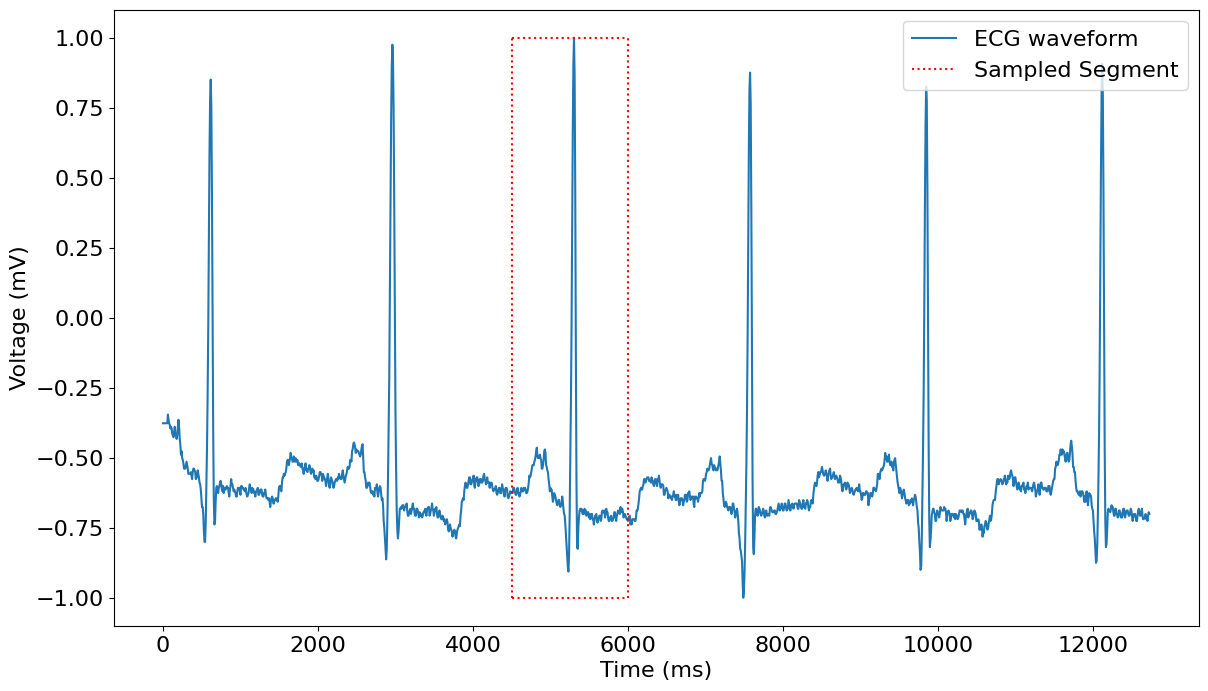

In [4]:

import matplotlib.pyplot as plt

sampling_freq = 125
num_samples = len(X_forecast)
time_ms = np.arange(num_samples) / sampling_freq * 1000

# Plot the ECG waveform
plt.figure(figsize=(14, 8))
plt.rcParams.update({'font.size': 16})
plt.plot(time_ms, X_forecast, label='ECG waveform')

# Calculate box width in ms
box_width = 187 * 1000 / sampling_freq
start_x = 4500

# Plot the box
plt.plot([start_x, start_x + box_width], [min(X_forecast), min(X_forecast)], linestyle=':', color='red', label="Sampled Segment")
plt.plot([start_x, start_x + box_width], [max(X_forecast), max(X_forecast)], linestyle=':', color='red')
plt.plot([start_x, start_x], [min(X_forecast), max(X_forecast)], linestyle=':', color='red')
plt.plot([start_x + box_width, start_x + box_width], [min(X_forecast), max(X_forecast)], linestyle=':', color='red')

plt.xlabel('Time (ms)')
plt.ylabel('Voltage (mV)')
plt.legend()
plt.show()

## 3. Loading our Classification Dataset

We begin by loading our ECG dataset using a function from our preprocessing module. This function provides flexibility with several parameters:

- `rows`: Specifies the number of instances to load. To maintain class balance, it's capped at 4015.
- `test_ratio`: Determines the portion of the dataset allocated to the test subset. We'll use 0.2 to reserve 20% for testing.
- `encode_labels`: Ensures that categorical labels are one-hot encoded, necessary for reservoirpy.
- `binary`: Indicates whether to merge all arrhythmia classes into one for binary classification.
- `noise_rate`: Determines the rate of noise applied to augmented instances, ranging between [0-1]
- `noise_ratio`: Determines the ratio of instances within the dataset to augment by percentage e.g. 0.2 == 20%

Let's utilize these parameters to load our dataset:

In [5]:
from utils.preprocessing import load_ecg_data

X_train, Y_train, X_test, Y_test = load_ecg_data(
    rows=4015,
    test_ratio=0.2,
    encode_labels=True,
    binary=False,
    noise_rate=0.2,
    noise_ratio=0.2)

2024-05-08 19:52:28 - [INFO] - Loading ECG Dataset
2024-05-08 19:52:28 - [DEBUG] - Loading preprocessed dataset from: data/ecg/ecg_data.npz
2024-05-08 19:52:29 - [DEBUG] - Balancing classes
2024-05-08 19:52:29 - [DEBUG] - Limiting instances to 5000 rows
2024-05-08 19:52:29 - [WARNING] - The 5000 rows requested were capped at 4015 rows to keep classes balanced.
2024-05-08 19:52:29 - [DEBUG] - Splitting dataset into training and testing sets
2024-05-08 19:52:29 - [DEBUG] - Train:Test dataset ratio: [80:20]
2024-05-08 19:52:29 - [DEBUG] - One-hot encoding labels.
2024-05-08 19:52:29 - [DEBUG] - Reshaping data into time-series.
2024-05-08 19:52:29 - [DEBUG] - ----- Dataset Parameters -----
2024-05-08 19:52:29 - [DEBUG] - instances: 4015
2024-05-08 19:52:29 - [DEBUG] - encode_labels: True
2024-05-08 19:52:29 - [DEBUG] - repeat_targets: False
2024-05-08 19:52:29 - [DEBUG] - standardize: True
2024-05-08 19:52:29 - [DEBUG] - test_ratio: 0.2
2024-05-08 19:52:29 - [DEBUG] - shuffle: True
2024-05

## 4. Visualizing our Dataset

### 4.1. Concatenating Training and Test Subsets

Before visualization, we concatenate the training and test subsets of our dataset into a single dataset, of targets `X` and labels `Y`.

In [6]:
# concatenate the training and test subsets into one
import numpy as np

X = np.concatenate((X_train, X_test), axis=0)
Y = np.concatenate((Y_train, Y_test), axis=0)

### 4.2. Plotting Dataset Distribution
We use the `plot_data_distribution` function to visualize the distribution of classes in our dataset and save the plot as "data-distribution.png".

Notably, we visualize the class balancing performed by our preprocessing module here.

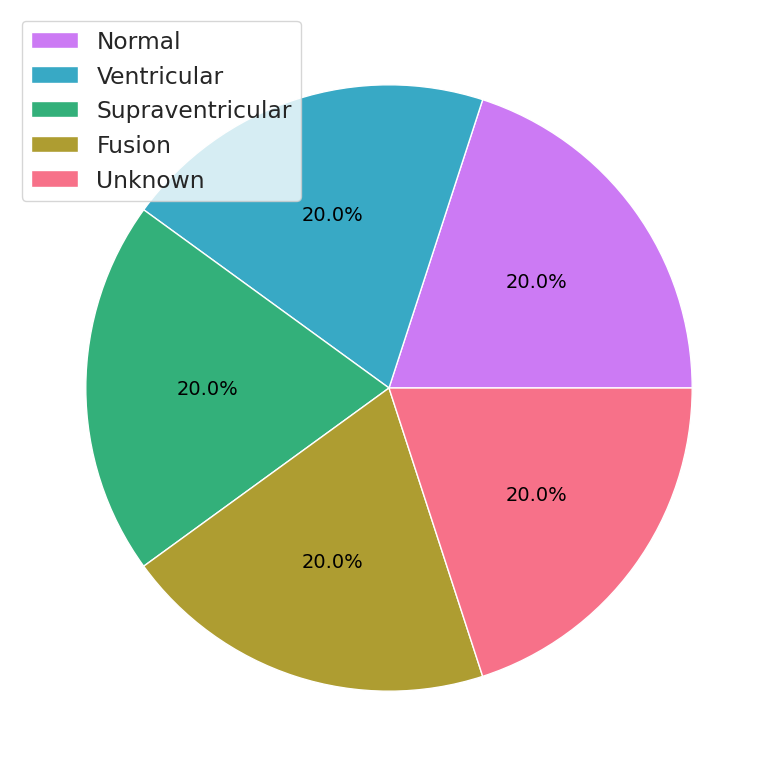

In [7]:
from utils.visualisation import plot_data_distribution

plot_data_distribution(Y, filename="data-distribution.png", show=True)

### 4.3. Plotting Dataset Information
Next, we use the plot_dataset_info function to visualize various statistics and information about our dataset, such as the total instances, class size, and the shape of our targets and labels respectively, which have been reshaped for reservoir computing classification input.

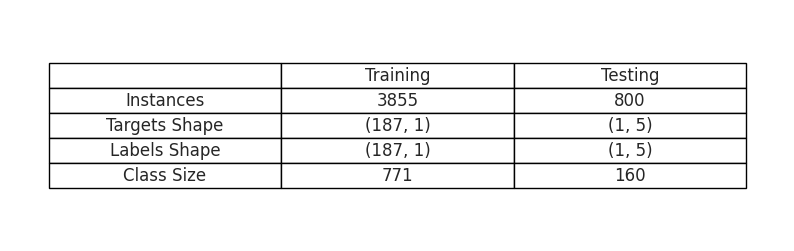

In [8]:
from utils.visualisation import plot_dataset_info

plot_dataset_info(X_train, Y_train, X_test, Y_test, filename="dataset-info.png", show=True)

### 4.4. Plotting Standard Deviation and Mean Across Classes
We further visualize the class standard deviation, and class mean using the corresponding functions.

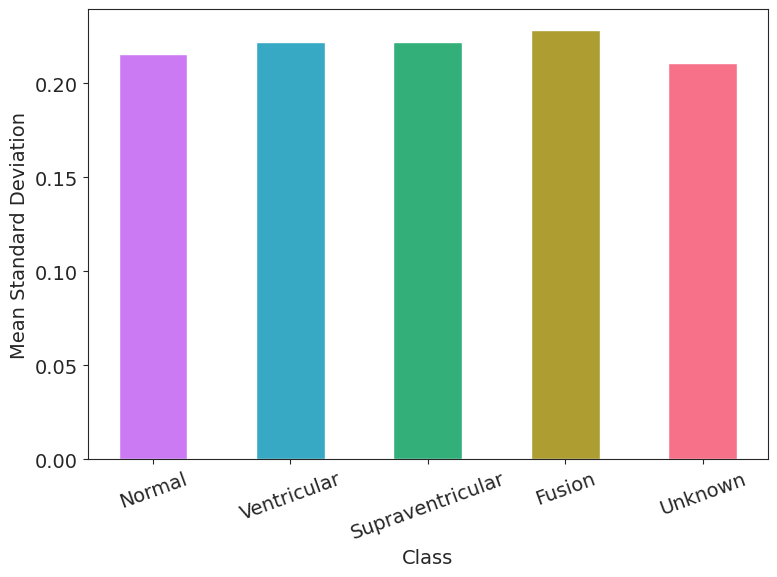

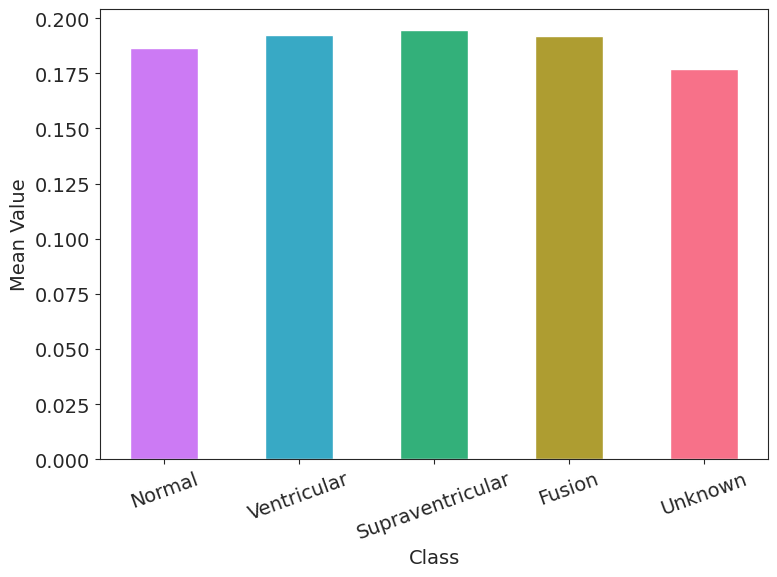

In [9]:
from utils.visualisation import plot_class_std
from utils.visualisation import plot_class_mean

plot_class_std(X, Y, filename="class-std.png", show=True)
plot_class_mean(X, Y, filename="class-means.png", show=True)

### 4.5. Visualising Class Averages
Next, we can visualise the average of each class with a single representative waveform which represents the mean of each time point within each class.

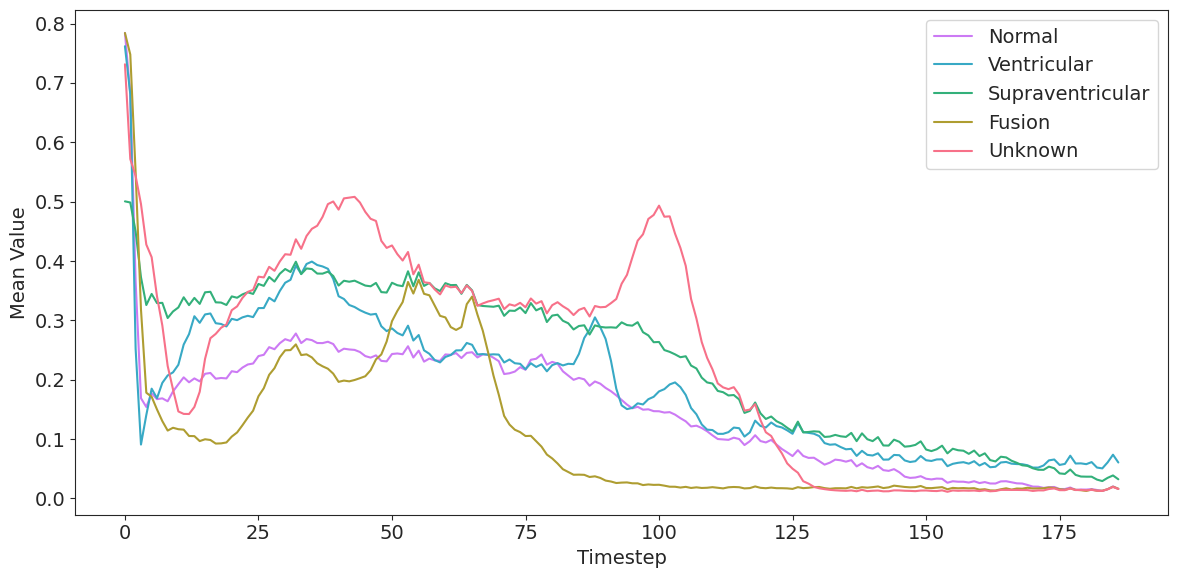

In [10]:
from utils.visualisation import plot_average_instance

plot_average_instance(X, Y, filename="average-instance.png", show=True)

# 5. Visualising Genetic Oscillators
In order to understand how our reservoir will operate, we can use a sine wave to test the forward function of a single Oscillator node.

### 5.1. Genetic Oscillators in Action
We can simulate the behaviour of gene expression using our Oscillator node by feeding in a continuous input of a sine wave over a period of 1000 timesteps.

Internally, our genetic oscillators are composed of a system of delay differential equations representing the interactions between the coupled genes luxI (I) and aiiA (A), commonly found in bacteria. luxI produces a quorum sensing molecule called AHL (Hi), which diffuses outside of the cell to, binding to the other cell's luxI promoters (He).

For each call of our Oscillator node's `forward` function, we receive an array of system states of shape (1, 4), where we have a single state for each variable in the system (A, I, Hi, He) at the current time point.

- `A` represents the aiiA gene, whilst `I` represents the luxI gene of the system.

- `Hi` and `He`, represent the internal and external AHL quorum-sensing molecules respectively.

We also apply a `coupling` coefficient to our sine wave input at each time step, representing the cell-to-cell coupling strength of cells within an engineered genetic circuit.

We can collect these states over the time series to represent the complete state of the system.

In [50]:
from reservoir.node import Oscillator
import numpy as np

timesteps = 1000
coupling = 1e-5
warmup = 100

timespan = np.linspace(0, timesteps, timesteps)
sine_wave = np.sin(timespan)

oscillator = Oscillator(timesteps=timesteps, warmup=warmup)

states = []
for state in oscillator.warmup_states:
    states.append(state)

for i in range(timesteps):
    states.append(oscillator.forward(sine_wave[i] * coupling))

states = np.array(states)

### 5.2. Visualising Genetic Oscillator States
We can now visualise the states of the coupled genes (A, I), as well as the internal and external signals (Hi, He) over the time period.

We can see the synchronized coupled oscillations by genes A and I, where the delayed He signal drives the production of the I gene promoter.

Notably, we can visualize the warmup process here, in which we run the system with no input for a number of time steps to initially promote gene concentrations, and save the states produced as the default permanent history of the node, preventing the need for warming up during each instance.

Oscillator States Shape:  (1100, 4)


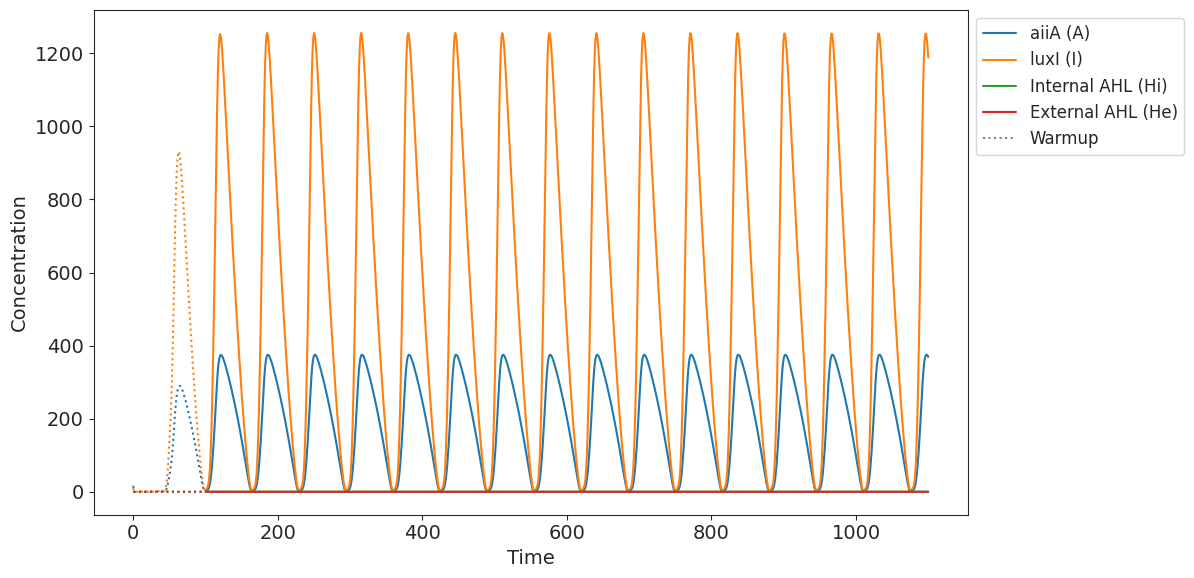

In [12]:
import matplotlib.pyplot as plt

print("Oscillator States Shape: ", states.shape)

timesteps = len(states)
time = np.linspace(0, timesteps, timesteps)
labels=["aiiA (A)", "luxI (I)", "Internal AHL (Hi)", "External AHL (He)"]

plt.figure(figsize=(10, 6))
for i in range(0, states.shape[1]):
    plt.plot(time[warmup:], states[warmup:, i], label=labels[i] if labels else None, color='C'+str(i))

# Plot warmup separately to ensure shared label in legend
for i in range(0, states.shape[1]):
    plt.plot(time[:warmup], states[:warmup, i], linestyle="dotted", color='C'+str(i))

# Add only one label for the warmup phase
plt.plot([], [], linestyle="dotted", label="Warmup", color='grey')
plt.rcParams.update({'font.size': 14})
plt.xlabel("Time")
plt.ylabel("Concentration")
plt.tight_layout()
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=12)
plt.show()

## 6. Constructing an Echo State Network
Here we will initialize our reservoir and readout nodes, the two key layers within an echo-state network.

### 6.1. Initializing the Reservoir
To initialize our reservoir we must supply a range of important hyperparameters:
- `timesteps` the timespan of each data instance, allows the Oscillator nodes to know when to reset their internal history.
- `nodes` the number of Oscillator nodes within the reservoir.
- `delay` the time delay of the external He signal within the genetic oscillators.

We construct a dictionary using the `delay` parameter to pass to the `OscillatorReservoir` as the `node_kwargs` parameter. The reservoir will propagate the parameters directly through to the Oscillator nodes as `**kwargs`.

Note, there are further hyper-parameters of the reservoir but for now we will focus on these as they are integral to our system producing oscillations.

In [13]:
from reservoir.reservoir import OscillatorReservoir

timesteps = X_train[0].shape[0]
print("Timesteps: ", timesteps)

nodes = 250
delay = 10

node_kwargs = {'delay': delay}

reservoir = OscillatorReservoir(
    units=nodes,
    timesteps=timesteps,
    node_kwargs=node_kwargs,
    seed=SEED,
    name="OscillatorReservoir")

print("Reservoir Hyperparameters: ", reservoir.hypers)

Timesteps:  187
Reservoir Hyperparameters:  {'timesteps': 187, 'coupling': 0.001, 'warmup': 40, 'sr': None, 'rc_scaling': 1e-06, 'input_scaling': 1.0, 'bias_scaling': 1.0, 'fb_scaling': 1.0, 'rc_connectivity': 0.1, 'input_connectivity': 0.1, 'fb_connectivity': 0.1, 'noise_in': 0.0, 'noise_rc': 0.0, 'noise_out': 0.0, 'noise_type': 'normal', 'units': 250, 'noise_generator': functools.partial(<function noise at 0x7f000ad59510>, rng=Generator(PCG64) at 0x7EFFF90C1460)}


### 6.2. Initializing our Readout Node
We will be using a reservoirpy `Ridge` node as our readout node which employs a layer of `N` neurons, where `N` is the number of classes in our task, each Ridge neuron uses regularized Tikhonov linear regression to perform learning.

In [14]:
from reservoirpy.nodes import Ridge

ridge = 1e-5
readout = Ridge(ridge=1e-5)

print("Ridge Hyperparameters: ", readout.hypers)

Ridge Hyperparameters:  {'ridge': 1e-05, 'input_bias': True}


### 6.3. Visualising Reservoir States
We can visualise the activation of our reservoir by plotting the states produced by our reservoir for the timeseries of a single instance of data.

Each line represents the luxI gene concentrations over a single instance's time series, for each node in the reservoir.

Here we can visualize the complex dynamics of each genetic oscillator node, allowing us to transform a one-dimensional input, into a matrix of shape `(timesteps, nodes)`, giving us a high-dimensional representation for each instance.

We can then map the high-dimensional representation of each instance to its true label during training.

Notably, the high range of phase differences between wave forms is representative of reservoir's environment, as each node within the reservoir has specific input and recurrent connectivity, affecting its weight, alongside further hyperparameters such as bias, and noise.

Reservoir States Shape:  (187, 250)


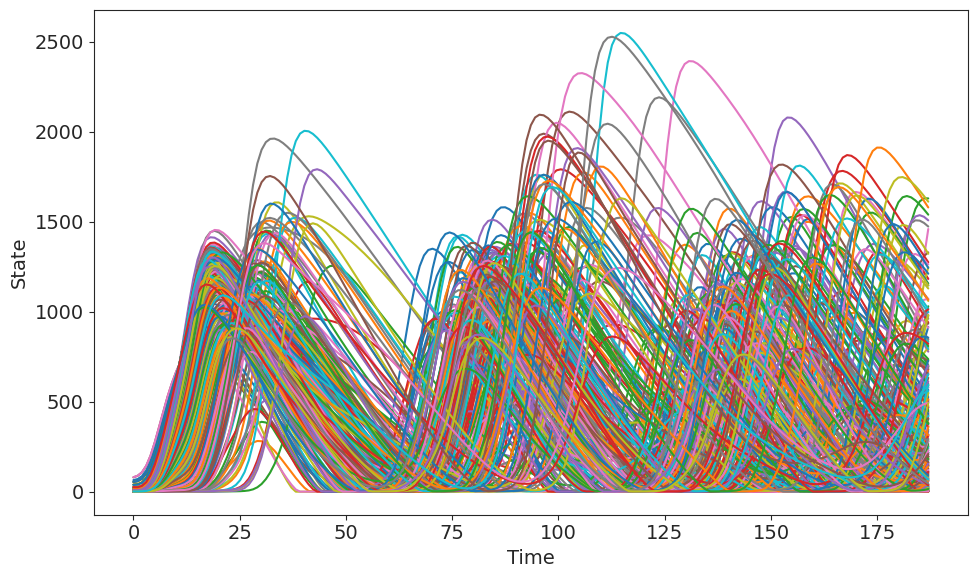

In [15]:
from utils.visualisation import plot_states

states = reservoir.run(X_train[0])
print("Reservoir States Shape: ", states.shape)

plot_states(states, legend=False)  # disable legend to not pollute the figure with node labels

## 7. Classification Optimization

With our classification dataset loaded and our echo state network (ESN) layers constructed, we're ready to perform classification.

However, we don't know what the best system parameters are, and so, using a high-performing computing cluster, we perform a grid search of system parameters, aiming to maximize the F1 score of the classification of arrhythmia.

### 7.1. Classification Objective
Here we define the objective for our hyperparameter optimization task, to do this we:
- Load our ECG classification dataset
- Initialize our `OscillatorReservoir` with the current trial's hyperparameters
- Initialize `Ridge` readout node
- Perform classification across 5 folds of cross validation
    - Notably, we add our data augmentation within each fold within the `classify` method.
- Report the F1 score for this setup.

As noted to ensure robustness, we utilize cross-validation to average our model performance metrics over k-folds. Additionally, we leverage multi-processing, allocating each fold to a new CPU core. This setup allows each fold to run independently with its copies of the reservoir and readout nodes.

In [16]:
from utils.classification import classify
from utils.preprocessing import load_ecg_data
from reservoir.reservoir import OscillatorReservoir

from reservoirpy.nodes import Ridge

def objective(trial, **kwargs):
    X_train, Y_train, X_test, Y_test = load_ecg_data(
        rows=kwargs['instances'],
        test_ratio=kwargs['test_ratio'],
        binary=kwargs['binary']
    )

    noise_ratio = trial.suggest_float("noise_ratio", 0, 1)
    noise_rate = trial.suggest_float("noise_rate", 0, 1)

    reservoir = OscillatorReservoir(
        units=trial.suggest_float("nodes", 0, 300),
        timesteps=X_train[0].shape[0],
        sr=trial.suggest_float("sr", 0, 2),
        warmup=trial.suggest_float("warmup", 0, 100),
        coupling=trial.suggest_float("coupling", 0, 1),
        rc_scaling=trial.suggest_float("rc_scaling", 0, 1),
        input_connectivity=trial.suggest_float("input_connectivity", 0, 1),
        rc_connectivity=trial.suggest_float("rc_connectivity", 0, 1),
        input_scaling=trial.suggest_float("input_scaling", 0, 1),
        bias_scaling=trial.suggest_float("bias_scaling", 0, 1),
        node_kwargs={'delay': kwargs['delay']},
        seed=kwargs['seed'])

    readout = Ridge(ridge=kwargs['ridge'])

    filename = f"results/runs/{kwargs['study_name']}-{trial.number}"

    metrics = classify(reservoir, readout, X_train, Y_train, X_test, Y_test, folds=kwargs['folds'],
                       save_file=filename, noise_rate=noise_rate, noise_ratio=noise_ratio)

    return metrics['f1']

### 7.2. Hyperparameter Optimization Research

Next, we create an `Optuna` study, and run the `research` method to find the best parameter over 5 trials.

Notably, we do not run the `research` method within this notebook due to the computationally intensive nature, instead we load an existing study from our local filesystem.

In [36]:
import optuna

from optimization.base import research

# Define the grid of parameter values as a dictionary
param_values = {
    'sr': [0.9, 1.0, 1.1],
    'nodes': [200, 225, 250],
    'input_connectivity': [0.1, 0.3, 0.5],
    'rc_connectivity': [0.1, 0.3, 0.5],
    'coupling': [1e-3, 5e-2, 5e-3],
    'warmup': [40, 50, 60],
    'rc_scaling': [4e-6, 8e-6],
    'input_scaling': [0.9, 1.0, 1.1],
    'bias_scaling': [0.9, 1.0, 1.1],
    'noise_ratio': [0.1, 0.2, 0.3],
    'noise_rate': [0.1, 0.2, 0.3]
}

# Create a list of parameter sets as dictionaries
study_params = {
    'delay': 10,
    'seed': 1337,
    'ridge': 1e-5,
    'instances': 4015,
    'binary': False,
    'test_ratio': 0.2,
    'folds': 5,
    'study_name': "classification"
}

processes = 1
trials = 5

# Create the study with the GridSampler
sampler = optuna.samplers.GridSampler(param_values)

log_name = f"logs/optuna-{study_params['study_name']}.db"
storage = optuna.storages.RDBStorage(f'sqlite:///{log_name}')
study = optuna.create_study(
    study_name=study_params['study_name'],
    direction='maximize',
    storage=storage,
    sampler=sampler,
    load_if_exists=True
)

# perform objective research
research(study, trials, objective, processes, **study_params)

[I 2024-05-08 19:57:20,904] Using an existing study with name 'classification' instead of creating a new one.


### 7.3. Evaluate Optimization Results

Once optimization is complete, we can report the results, in which we discover the optimal set of system hyperparameters, alongside the resulting F1 score.

In [37]:
from optimization.base import evaluate_study

evaluate_study(study.trials_dataframe(), objective_str="F1 Score")


Best Parameters:
 - bias_scaling: 1.0
 - coupling: 0.001
 - input_connectivity: 0.3
 - input_scaling: 0.9
 - nodes: 225.0
 - noise_rate: 0.1
 - noise_ratio: 0.1
 - rc_connectivity: 0.1
 - rc_scaling: 8e-06
 - sr: 1.0
 - warmup: 40.0

Best F1 Score:  0.8401483618297607
Trial:  32


### 7.4. Plot Optimization Results

We can plot the slice plot of our study's optimization trials here, depicting the F1 score of each trial, each with a unique set of hyperparameters.

/home/james/uni/dissertation/optimization/base.py:76: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  plot_func(study=study, params=params)


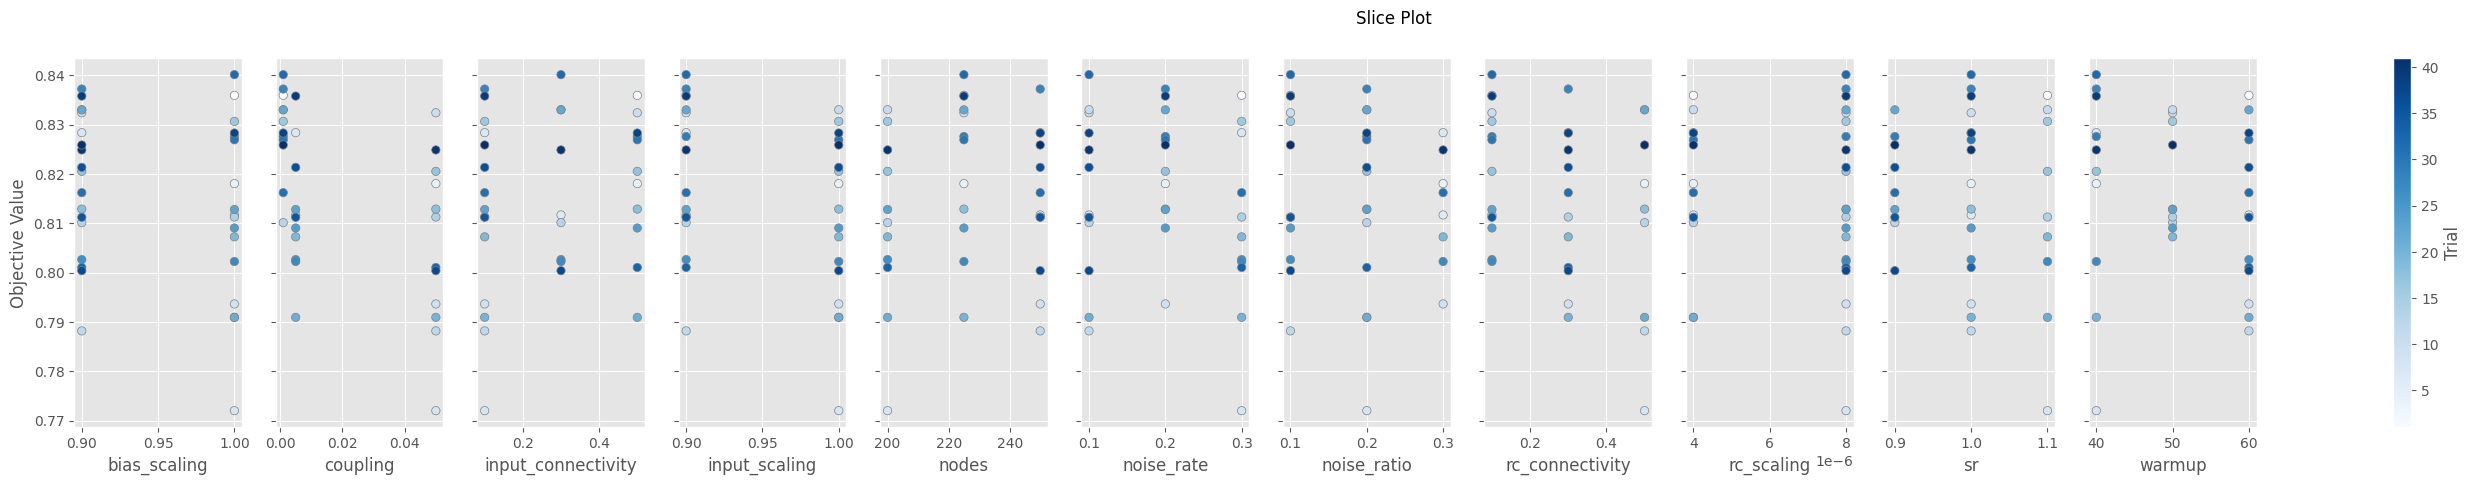

In [38]:
from optimization.base import plot_results

from optuna.visualization.matplotlib import plot_slice

plot_results(study, plot_slice, filename="classification-slice.png")

### 7.5. Plot Hyperparameter Importances

We can explain the importance of each hyperparameter within the slice plot above using the following visualization.

/home/james/uni/dissertation/optimization/base.py:76: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  plot_func(study=study, params=params)


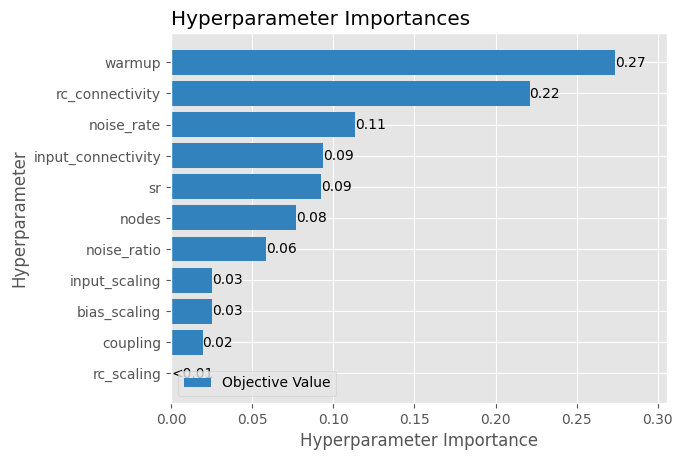

In [39]:
from optuna.visualization.matplotlib import plot_param_importances

plot_results(study, plot_param_importances, filename="classification-importances.png")

# reset matplotlib styling (optuna updates it globally)
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({'font.size': 15})

## 8. Readout Layer Optimization

After we have discovered the optimal system hyperparameters, we can now optimize our readout node.

During the previous optimization, we saved the important metadata to files, allowing us to utilize the states produced in order to train a range of different classifiers.

We load the data which the `classify` function has just saved to our local `results/runs` directory which contains the performance metrics, model hyperparameters, and predicted labels.

In [40]:
from utils.preprocessing import load_npz

best_trial = 32

filename = f"results/runs/{study_params['study_name']}-{best_trial}"

folds_data = []

folds = 5

# extract each fold from the classification results
for fold in range(folds):
    fold_filename = filename + f"-fold-{str(fold)}.npz"
    fold_data = load_npz(fold_filename, allow_pickle=True)
    folds_data.append(fold_data)

### 8.1. Extracting Trained States

In order to fit and run our readout nodes, we require the previously trained reservoir states, for both our training and test sets, as well as their corresponding labels.

In [41]:
fold_states = {fold: {} for fold in range(folds)}

# extract the trained states for each fold
for fold in range(folds):
    # Load trained states and matching labels
    trained_states = folds_data[fold]['train_states']
    tested_states = folds_data[fold]['test_states']
    Y_train = folds_data[fold]['Y_train']
    Y_test = folds_data[fold]['Y_test']

    # Reshape arrays
    trained_states = trained_states.reshape(trained_states.shape[0], 1, -1)
    tested_states = tested_states.reshape(tested_states.shape[0], 1, -1)
    Y_train = Y_train.reshape(Y_train.shape[0], 1, -1)
    Y_test = Y_test.reshape(Y_test.shape[0], 1, -1)

    # Populate fold_states dictionary
    fold_states[fold]['trained_states'] = trained_states
    fold_states[fold]['tested_states'] = tested_states
    fold_states[fold]['Y_train'] = Y_train
    fold_states[fold]['Y_test'] = Y_test

### 8.2. Analysing Different Classifiers
Although we use Ridge as our default classifier, we can use a range of classifiers to analyse the differences, we define our `Optuna` optimization objective here.

We perform a random sampling search over a range of hyperparameters for a range of different classifiers from `sklearn`.

In [43]:

from reservoirpy.nodes import ScikitLearnNode
from sklearn.linear_model import RidgeClassifier, LogisticRegression, Perceptron
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

from utils.classification import evaluate_performance

def objective(trial, **kwargs):
    # use the first fold to compare performance between classifiers
    trained_states = fold_states[0]['trained_states']
    tested_states = fold_states[0]['tested_states']
    Y_train = fold_states[0]['Y_train']
    Y_test = fold_states[0]['Y_test']

    classifier_name = trial.suggest_categorical('classifier', kwargs['classifiers'])

    if classifier_name == "Ridge":
        hypers = {
            "alpha": trial.suggest_float('ridge_alpha', 1e-5, 1e2, log=True),
            "fit_intercept": trial.suggest_categorical('ridge_fit_intercept', [True, False]),
            "copy_X": trial.suggest_categorical('ridge_copy_X', [True, False]),
            "tol": trial.suggest_float('ridge_tol', 1e-5, 1e-1, log=True),
            "solver": trial.suggest_categorical('ridge_solver', ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']),
        }
        clf = RidgeClassifier

    elif classifier_name == "Bayes":
        hypers = {
            "var_smoothing": trial.suggest_float('bayes_var_smoothing', 1e-12, 1e-4),
        }
        clf = GaussianNB

    elif classifier_name == "LR":
        hypers = {
            "tol": trial.suggest_float('lr_tol', 1e-5, 1e-1, log=True),
            "C": trial.suggest_float('lr_C', 1e-5, 1e5, log=True),
            "fit_intercept": trial.suggest_categorical('lr_fit_intercept', [True, False]),
            "intercept_scaling": trial.suggest_float('lr_intercept_scaling', 0.1, 10),
            "solver": trial.suggest_categorical('lr_solver', ['lbfgs', 'liblinear', 'newton-cg', 'sag', 'saga']),
            "max_iter": 1000,
        }
        clf = LogisticRegression

    elif classifier_name == "Perceptron":
        hypers = {
            "penalty": trial.suggest_categorical('perceptron_penalty', [None, 'l2', 'l1', 'elasticnet']),
            "alpha": trial.suggest_float('perceptron_alpha', 1e-5, 1e-2, log=True),
            "l1_ratio": trial.suggest_float('perceptron_l1_ratio', 0, 1),
            "fit_intercept": trial.suggest_categorical('perceptron_fit_intercept', [True, False]),
            "tol": trial.suggest_float('perceptron_tol', 1e-5, 1e-1, log=True),
            "eta0": trial.suggest_float('perceptron_eta0', 1e-4, 1, log=True),
        }
        clf = Perceptron

    elif classifier_name == "SVM":
        kernel = trial.suggest_categorical('svc_kernel', ['linear', 'poly', 'rbf', 'sigmoid'])
        hypers = {
            "C": trial.suggest_float('svc_C', 1e-5, 1e4, log=True),
            "kernel": kernel,
            "degree": trial.suggest_int('svc_degree', 1, 5),
            "gamma": trial.suggest_categorical('svc_gamma', ['scale', 'auto']) if kernel != 'linear' else 'scale',
            "tol": trial.suggest_float('svc_tol', 1e-5, 1e-2, log=True),
        }
        clf = SVC

    elif classifier_name == "MLP":
        hypers = {
            "hidden_layer_sizes": trial.suggest_int('mlp_hidden_layer_sizes', 100, 300),
            "activation": trial.suggest_categorical('mlp_activation', ['logistic', 'tanh', 'relu']),
            "solver": trial.suggest_categorical('mlp_solver', ['lbfgs', 'adam']),
            "alpha": trial.suggest_float('mlp_alpha', 1e-5, 1e-3, log=True),
            "learning_rate": trial.suggest_categorical('mlp_learning_type', ['constant', 'invscaling']),
            "learning_rate_init": trial.suggest_float('mlp_learning_rate_init', 1e-5, 1e-3, log=True),
            "power_t": trial.suggest_float('mlp_power_t', 0.1, 1.0),
            "tol": trial.suggest_float('mlp_tol', 1e-5, 1e-1, log=True),
            "momentum": trial.suggest_float('mlp_momentum', 0.1, 0.9),
            "epsilon": trial.suggest_float('mlp_epsilon', 1e-8, 1e-6, log=True),
            "max_iter": 1000,
        }
        clf = MLPClassifier

    elif classifier_name == "KNN":
        hypers = {
            "n_neighbors": trial.suggest_int('knn_n_neighbors', 1, 20),
            "weights": trial.suggest_categorical('knn_weights', ['uniform', 'distance']),
            "algorithm": trial.suggest_categorical('knn_algorithm', ['auto', 'ball_tree', 'kd_tree', 'brute']),
            "leaf_size": trial.suggest_int('knn_leaf_size', 10, 50),
            "p": trial.suggest_float('knn_p', 1.0, 2.0)
        }
        clf = KNeighborsClassifier

    elif classifier_name == "DT":
        hypers = {
            "criterion": trial.suggest_categorical('dt_criterion', ["gini", "entropy", "log_loss"]),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        }
        clf = DecisionTreeClassifier

    elif classifier_name == "RF":
        hypers = {
                "n_estimators": trial.suggest_int('rf_n_estimators', 100, 500),
                "criterion": trial.suggest_categorical('rf_criterion', ["gini", "entropy", "log_loss"]),
                "oob_score": trial.suggest_categorical('rf_oob_score', [True, False]),
            }
        clf = RandomForestClassifier

    elif classifier_name == "GB":
        hypers = {
            "loss": trial.suggest_categorical('gb_loss', ['log_loss', 'exponential']),
            "learning_rate": trial.suggest_float('gb_learning_rate', 0.001, 1.0),
            "n_estimators": trial.suggest_int('gb_n_estimators', 100, 500),
            "subsample": trial.suggest_float('gb_subsample', 0.1, 1.0),
            "criterion": trial.suggest_categorical('gb_criterion', ['friedman_mse', 'squared_error']),
        }
        clf = GradientBoostingClassifier

    node = ScikitLearnNode(clf, model_hypers=hypers)

    logger.debug(f"Fitting {classifier_name}")
    node.fit(trained_states, Y_train)

    logger.debug(f"Running {classifier_name}")
    Y_pred = node.run(tested_states)
    return evaluate_performance(Y_pred, Y_test)['f1']

### 8.3. Performing Readout Optimization

We perform readout optimization in the same manor as the reservoir optimization, except we use random sampling over grid searching due to the much quicker run-time of the readout nodes, facilitating a much greater range of trials.

We also do not perform this optimization within the notebook, and instead load previous results.

In [44]:
import numpy as np

study_params = {
    'classifiers': ["Ridge", "Bayes", "LR", "Perceptron", "SVM", "MLP", "KNN", "DT", "RF", "GB"],
    'study_name': "readout"
}

db_name = f"logs/optuna-{study_params['study_name']}.db"
trials = 5
processes = 1

storage = optuna.storages.RDBStorage(f'sqlite:///{db_name}')
seed = np.random.randint(0, 10000)
sampler = optuna.samplers.RandomSampler(seed=seed)

study = optuna.create_study(
    study_name=study_params['study_name'],
    direction='maximize',
    storage=storage,
    sampler=sampler,
    load_if_exists=True
)

study = research(study, trials, objective, processes, **params)

[I 2024-05-08 19:57:51,065] Using an existing study with name 'readout' instead of creating a new one.


### 8.4. Evaluating Readout Optimization Performance

In [45]:
import optuna

from optimization.base import evaluate_study

db_name = f"logs/optuna-{study_params['study_name']}.db"
storage = optuna.storages.RDBStorage(f'sqlite:///{db_name}')

study = optuna.load_study(study_name=study_params['study_name'], storage=storage)

classifiers = ["Ridge", "Bayes", "LR", "Perceptron", "SVM", "MLP", "KNN", "DT", "RF", "GB"]

# Run optimization for each classifier
for classifier_name in classifiers:
    study_df = study.trials_dataframe()
    idx = study_df['params_classifier'] == classifier_name
    classifier_study = study_df[idx]
    evaluate_study(classifier_study, "F1 Score")


Best Parameters:
 - classifier: Ridge
 - ridge_alpha: 15.583184003796157
 - ridge_copy_X: True
 - ridge_fit_intercept: True
 - ridge_solver: auto
 - ridge_tol: 0.06879014992913297

Best F1 Score:  0.8244643902249839
Trial:  7587

Best Parameters:
 - bayes_var_smoothing: 3.702514738157703e-08
 - classifier: Bayes

Best F1 Score:  0.44750288022061757
Trial:  3174

Best Parameters:
 - classifier: LR
 - lr_C: 4715.944242794145
 - lr_fit_intercept: False
 - lr_intercept_scaling: 7.562663781277023
 - lr_solver: newton-cg
 - lr_tol: 6.17458341931806e-05

Best F1 Score:  0.8571683251314733
Trial:  5408

Best Parameters:
 - classifier: Perceptron
 - perceptron_alpha: 7.821564861578316e-05
 - perceptron_eta0: 0.5758391353118988
 - perceptron_fit_intercept: False
 - perceptron_l1_ratio: 0.2637686074243367
 - perceptron_penalty: l1
 - perceptron_tol: 0.0012583294654216603

Best F1 Score:  0.7454179173733086
Trial:  8399

Best Parameters:
 - classifier: SVM
 - svc_C: 1.9412539478976926e-05
 - svc_

## 9. Performing Optimized Classification
 
Now that we have both of our results for reservoir and readout optimization, we must perform one final classification to concatenate these results across cross validation folds.

Notably, the gradient boosting algorithm performed the best, however, due to its computationally intensive nature, we choose to continue with the K-Nearest Neighbors classifier, which followed closely behind in terms of performance.

We use the best run from our K-Nearest Neighbors optimization study to construct a readout node with the optimized parameters, and perform prediction across the 5 cross-validation folds using our optimized reservoir states.

In [46]:
import time

from sklearn.neighbors import KNeighborsClassifier
from reservoirpy.nodes import ScikitLearnNode

from utils.analysis import evaluate_performance

classifier = KNeighborsClassifier
name = "K-Nearest Neighbors"
node_params = {"n_neighbors": 3, "algorithm": "ball_tree", "leaf_size": 14, "p": 1.5, "weights": "uniform"}

results = []

for idx, fold in enumerate(range(folds)):
    print(f"\nCross-validation fold {idx}:")
    # Extract data for the current fold
    trained_states = fold_states[fold]['trained_states']
    tested_states = fold_states[fold]['tested_states']
    Y_train = fold_states[fold]['Y_train']
    Y_test = fold_states[fold]['Y_test']

    # Initialize ScikitLearnNode
    node = ScikitLearnNode(classifier, model_hypers=node_params, name=f"{name}-{idx}")

    # Fit the node and make predictions
    start = time.time()
    print(f"Fitting {name}")
    node.fit(trained_states, Y_train)

    print(f"Running {name}")
    Y_pred = node.run(tested_states)
    runtime = time.time() - start

    # Compute metrics for the node
    node_metrics = evaluate_performance(Y_pred, Y_test, runtime)
    
    # Store data for the classifier
    results.append({
        "train_states": trained_states,
        "test_states": tested_states,
        "Y_test": Y_test,
        "Y_pred": Y_pred,
        "metrics": node_metrics
    })


Cross-validation fold 0:
Fitting K-Nearest Neighbors
Running K-Nearest Neighbors
2024-05-08 19:58:16 - [INFO] - Calculating model performance metrics

Cross-validation fold 1:
Fitting K-Nearest Neighbors
Running K-Nearest Neighbors
2024-05-08 19:58:25 - [INFO] - Calculating model performance metrics

Cross-validation fold 2:
Fitting K-Nearest Neighbors
Running K-Nearest Neighbors
2024-05-08 19:58:34 - [INFO] - Calculating model performance metrics

Cross-validation fold 3:
Fitting K-Nearest Neighbors
Running K-Nearest Neighbors
2024-05-08 19:58:42 - [INFO] - Calculating model performance metrics

Cross-validation fold 4:
Fitting K-Nearest Neighbors
Running K-Nearest Neighbors
2024-05-08 19:58:50 - [INFO] - Calculating model performance metrics


### 9.1. Compute Final Classification Metrics

We compute our final classification metrics by computing the mean of each metric across the cross validation folds.

In [27]:
from utils.analysis import log_metrics
from utils.analysis import compute_mean_metrics

# extract the metrics for each fold
fold_metrics = [results[fold]['metrics'] for fold in range(folds)]

# compute the mean of the metrics across the folds
metrics = compute_mean_metrics(fold_metrics)

log_metrics(metrics)

2024-05-08 19:54:14 - [INFO] - ----- Classification Report -----
2024-05-08 19:54:14 - [INFO] - runtime: 8.830
2024-05-08 19:54:14 - [INFO] - accuracy: 0.861
2024-05-08 19:54:14 - [INFO] - f1: 0.860
2024-05-08 19:54:14 - [INFO] - recall: 0.861
2024-05-08 19:54:14 - [INFO] - precision: 0.861
2024-05-08 19:54:14 - [INFO] - mse: 0.638
2024-05-08 19:54:14 - [INFO] - rmse: 0.798
2024-05-08 19:54:14 - [INFO] - r2_score: 0.689
2024-05-08 19:54:14 - [INFO] - ---------------------------------


## 10. Analysing Performance Metrics
Once classification is complete, we can plot the resulting metrics to understand how our model performed.

### 10.1. Deviation Across Folds
We can plot the difference of the metrics per fold, visualising how shuffling the dataset effects the model.
    - We should see high-similarity between folds which indicates that our model has not overfitted.

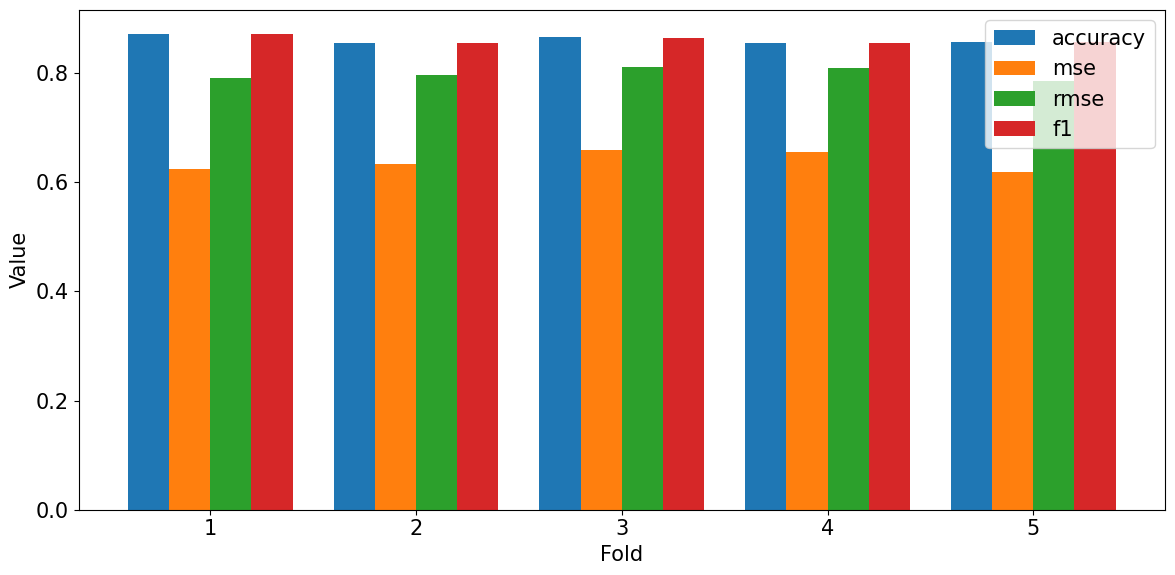

In [35]:
from utils.visualisation import plot_metrics_across_folds

plot_metrics_across_folds(fold_metrics)

### 10.2. Class Prediction Metrics
Next, we can plot the precision, recall, and F1 score of each class, indicating the model's ability to predict each class individually.

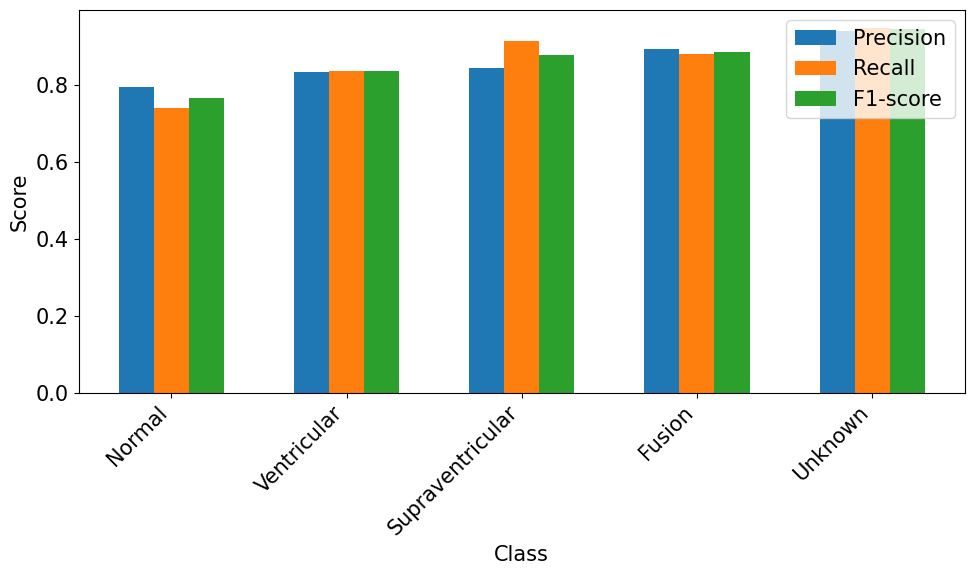

In [47]:
from utils.visualisation import plot_class_metrics

plot_class_metrics(metrics['class_metrics'])

### 10.3. Confusion Matrix
We can also plot the confusion matrix, which visualises the true labels against the model's predictions:

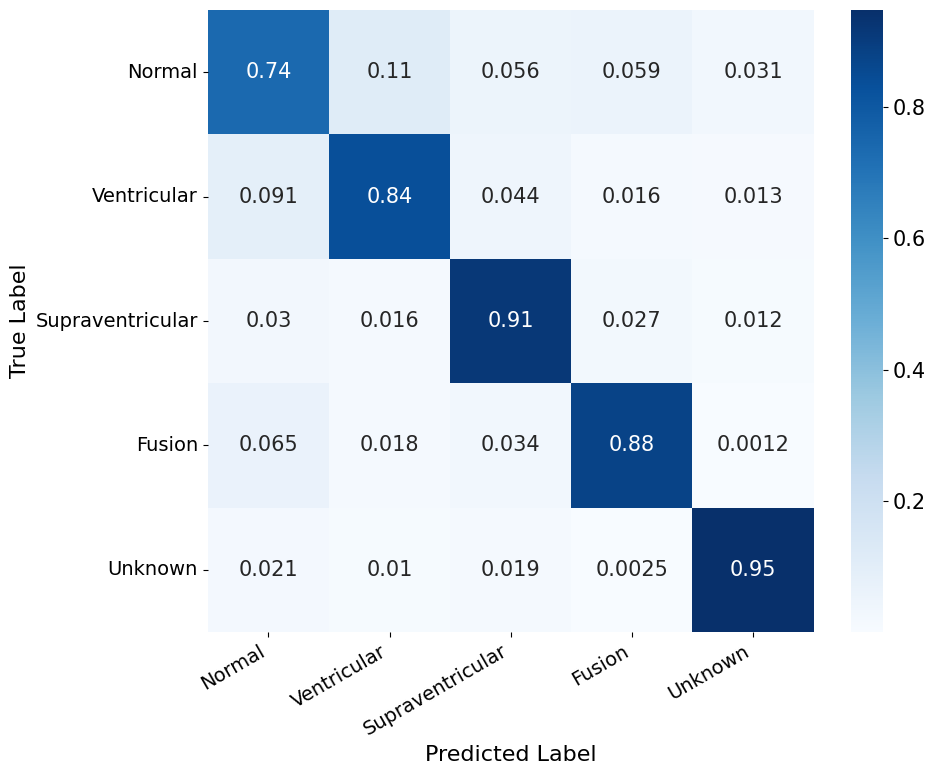

In [48]:
from utils.visualisation import plot_confusion_matrix

plot_confusion_matrix(metrics['confusion_matrix'])

### 10.4. Pediction Clustering
Finally, we can plot the t-SNE clustering of our model's predictions which visualises the underlying non-linear relationships between predictions by class.

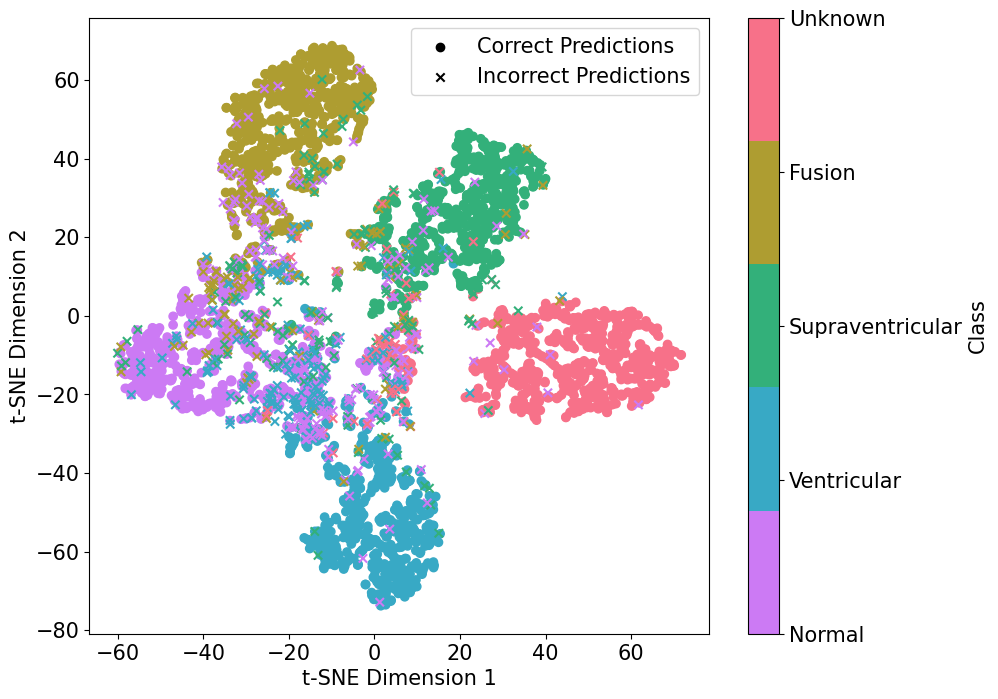

In [49]:
from utils.visualisation import plot_tsne_clustering
import numpy as np

# concatenate the predictions across the folds
Y_pred = []
Y_true = []
for fold in range(folds):
    Y_pred.append(folds_data[fold]['Y_pred'])
    Y_true.append(folds_data[fold]['Y_test'])

Y_pred = np.concatenate(Y_pred)
Y_true = np.concatenate(Y_true)

plot_tsne_clustering(Y_pred, Y_true, show=True)